# Image Format vs Fossil Repository Size

## Prerequisites

This notebook was developed with [JupyterLab][jl]. To follow in my footsteps, install that and the needed Python packages:

    $ pip install jupyterlab matplotlib pandas wand

In principle, it should also work with [Anaconda Navigator][an], but because [Wand][wp] is not currently in the Anaconda base package set, you may run into difficulties making it work, as we did on macOS. There seems to be some sandboxing that causes problems with OS interaction in that environment. Therefore, we recommend using straight JupyterLab.

This notebook was originally written for the Python 2 kernel because macOS does not include Python 3, but it was later updated for Python 3. It should still be compatible with Python 2, though.

[an]: https://www.anaconda.com/distribution/
[jl]: https://github.com/jupyterlab/
[wp]: http://wand-py.org/


## Running

The next cell generates the test repositories. This takes about 45 seconds to run, primarily due to the `sleep 1` synchronization call, made 40 times in the main test loop.

The one after that produces the bar chart from the collected data, all but instantaneously.

This split allows you to generate the expensive experimental data in a single pass, then play as many games as you like with the generated data.


## Discussion

That is kept in [a separate document](image-format-vs-repo-size.md) so we can share that document with Fossil's Markdown renderer.

In [1]:
import os
import random
import time

from wand.color import Color
from wand.drawing import Drawing
from wand.image import Image

import pandas as pd

size = 256
iterations = 10
start = time.time()
repo_sizes = []

formats = ['JPEG', 'BMP', 'TIFF', 'PNG']
for f in formats:
    ext = f.lower()
    tdir = 'test' + '-' + ext
    repo = tdir + '.fossil'
    ifn = 'test.' + ext
    ipath = os.path.join(tdir, ifn)
    rs = []
    
    def add_repo_size():
        rs.append(os.path.getsize(repo) / 1024.0 / 1024.0)

    try:
        # Create test repo
        if not os.path.exists(tdir): os.mkdir(tdir, 0o700)
        cmd = 'cd {0} ; fossil init ../{1} && fossil open --nested ../{1} && fossil set binary-glob "*.{2}"'.format(
            tdir, repo, ext
        )
        if os.system(cmd) != 0:
            raise RuntimeError('Failed to create test repo ' + repo)
        add_repo_size()

        # Create test image and add it to the repo
        img = Image(width = size, height = size, depth = 8,
                    background = 'white')
        img.alpha_channel = 'remove'
        img.evaluate('gaussiannoise', 1.0)
        img.save(filename = ipath)
        cmd = 'cd {0} ; fossil add {1} && fossil ci -m "initial"'.format(
            tdir, ifn
        )
        if os.system(cmd) != 0:
            raise RuntimeError('Failed to add ' + ifn + ' to test repo')
        #print "Created test repo " + repo + " for format " + f + "."
        add_repo_size()

        # Change a random pixel to a random RGB value and check it in
        # $iterations times.
        for i in range(iterations):
            with Drawing() as draw:
                x = random.randint(0, size - 1)
                y = random.randint(0, size - 1)

                r = random.randint(0, 255)
                g = random.randint(0, 255)
                b = random.randint(0, 255)
                
                draw.fill_color = Color('rgb({0},{1},{2})'.format(
                    r, g, b
                ))
                draw.color(x, y, 'point')
                draw(img)
                img.save(filename = ipath)
                
                # ImageMagick appears to use some kind of asynchronous
                # file saving mechanism, so we have to give it time to
                # complete.
                time.sleep(1.0)
  
                cmd = 'cd {0} ; fossil ci -m "change {1} step {2}"'.format(
                    tdir, f, i
                )
                if os.system(cmd) != 0:
                    raise RuntimeError('Failed to change ' + f + ' image, step ' + str(i))
                add_repo_size()
                
        # Repo complete for this format
        repo_sizes.append(pd.Series(rs, name=f))

    finally:
        if os.path.exists(ipath): os.remove(ipath)
        if os.path.exists(tdir):
            os.system('cd ' + tdir + ' ; fossil close -f')
            os.rmdir(tdir)
        if os.path.exists(repo): os.remove(repo)
            
print("Experiment completed in " + str(time.time() - start) + " seconds.")

Experiment completed in 44.186978816986084 seconds.


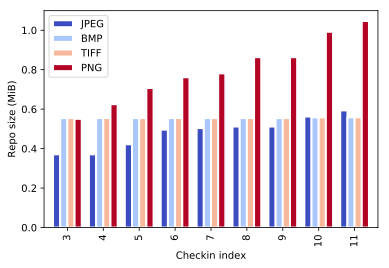

In [2]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib as mpl
import matplotlib.pyplot as plt

# Merge per-format test data into a single DataFrame without the first
# first 3 rows: the initial empty repo state (boring) and the repo DB
# size as it "settles" in its first few checkins.
data = pd.concat(repo_sizes, axis=1).drop(range(3))

mpl.rcParams['figure.figsize'] = (6, 4)
ax = data.plot(kind = 'bar', colormap = 'coolwarm',
          grid = False, width = 0.8,
          edgecolor = 'white', linewidth = 2)
ax.axes.set_xlabel('Checkin index')
ax.axes.set_ylabel('Repo size (MiB)')
plt.savefig('image-format-vs-repo-size.svg', transparent=True)
plt.show()